# Sommaire

* [Contexte du Projet](#Contexte-du-Projet)
* [Import](#Import-des-librairie)
* [Dataset](#Dataset)    
    * [analyse de forme](#analyse-de-forme)
    * [Data Cleaning](#data-cleaning)
* [Visualisation](#Visualisation)
    * [Outliers](#outliers)
    * [Features](#Features)
    * [Composition](#Composition-of-Open-variable)
* [Model](#model)
    * [Preprocessing](#Preprocessing)
    * [Train Test Split](#train-test-split)
    * [Model LSTM](#Model-LSTM)
* [Testing new data](#Testing-new-data)

# Contexte du projet
Vous êtes datascientist chez Google en charge d'un nouveau projet autour de TimeSeries. Votre premier projet consiste à proposer une solution permettant de prédire la tendance de l'action Google dans le futur et de former une nouvelle équipe de datascientists (juniors) sur les RNN et en particulier les LSTM.

Pour réaliser ce projet, vous avez accés à deux datasets :

dataset Train : 5 années d’historique de l’action google 2012 - 2016
-dataset Test : un mois de données Janvier 2017

https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

# Import des librairie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# warnings.simplefilter('ignore')
from datetime import datetime
import seaborn as sns

# Dataset

In [2]:
df= pd.read_csv('Google_Stock_data_train.csv',parse_dates=['Date'],index_col=['Date'])

In [3]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


## analyse de forme

In [4]:
df.duplicated().sum()

0

In [5]:
df.shape

(1258, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [7]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## data cleaning

In [9]:
df_clean = df

In [10]:
df_clean["Volume"] = df_clean["Volume"].str.replace(",","").astype(float)

# Visualisation

## outliers

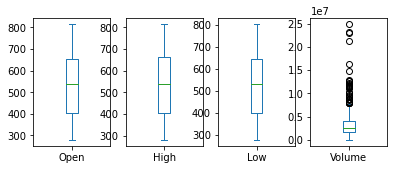

In [11]:
df_clean.plot(kind='box', subplots=True, layout=(3, 5), figsize=(8, 8));

## Features

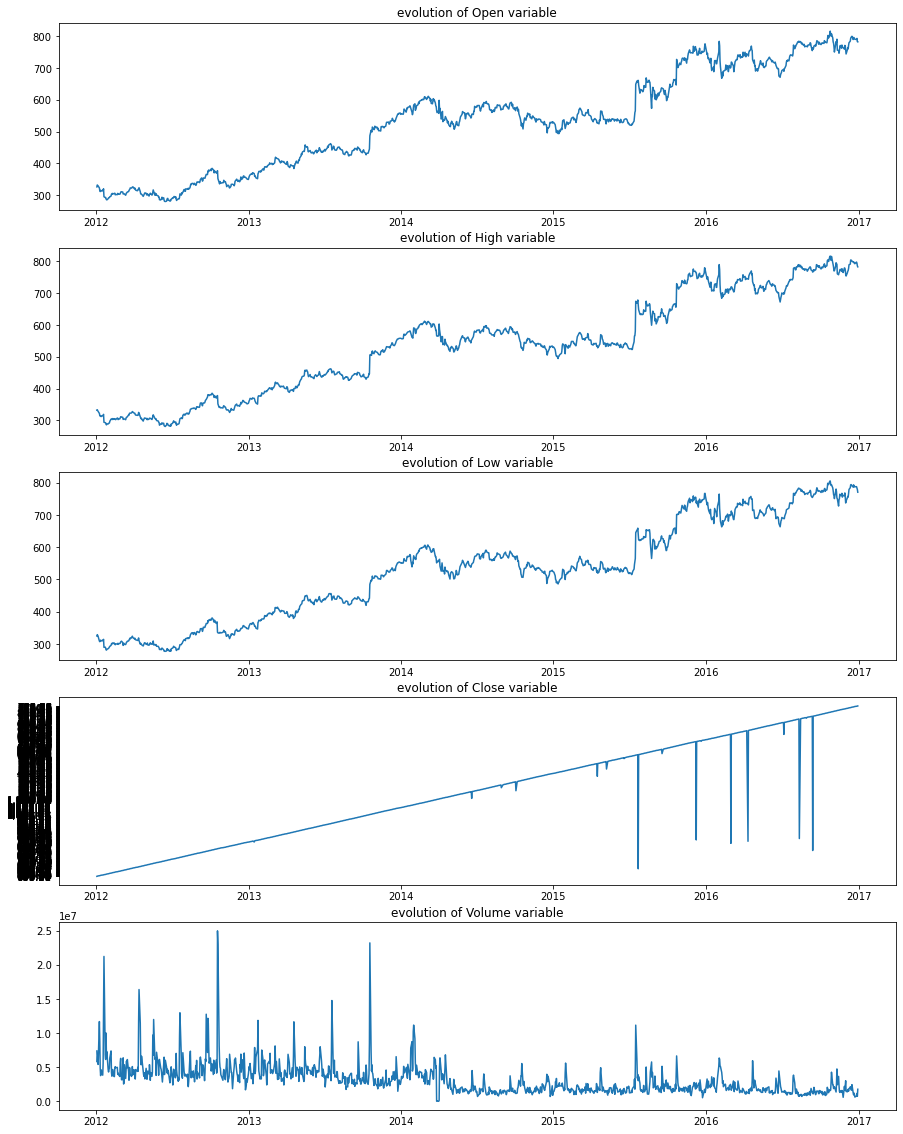

In [12]:
plt.figure(figsize=(15,20))

for i in range(len(df_clean.columns)):
    plt.subplot(len(df_clean.columns), 1, i+1)
    name = df_clean.columns[i]
    plt.plot(df_clean[name])
    plt.title(name, y=0)
    plt.title(f"evolution of {name} variable")


plt.show()

## Composition of Open variable

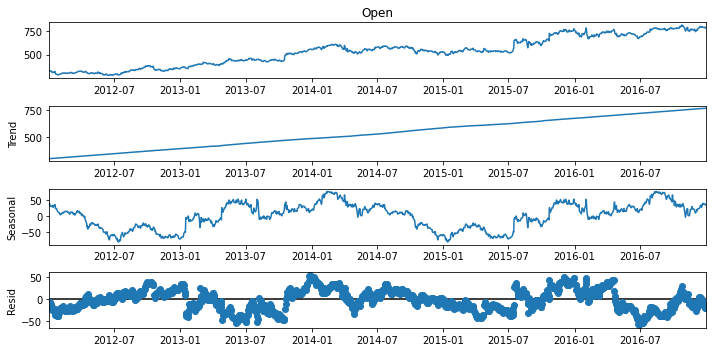

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = 10, 5
# Additive decomposition
decomposed_add = seasonal_decompose(df_clean['Open'], model="additive", extrapolate_trend='freq', period=int(len(df_clean['Open'])/2))
add = decomposed_add.plot()
plt.show()

# model

## Preprocessing

In [14]:
data = df_clean.filter(['Open'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1196

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

## train test split 

In [16]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape


In [17]:
x_train.shape

(1136, 60, 1)

## Model LSTM 

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError
import tensorflow as tf
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=100,validation_split=0.3)

Epoch 1/100
25/25 [==============================] - 22s 104ms/step - loss: 0.0409 - root_mean_squared_error: 0.2509 - val_loss: 0.0080 - val_root_mean_squared_error: 0.1257
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0022 - root_mean_squared_error: 0.1135 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0943
Epoch 3/100
25/25 [==============================] - 1s 55ms/step - loss: 6.9603e-04 - root_mean_squared_error: 0.0882 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0790
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 6.6393e-04 - root_mean_squared_error: 0.0758 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0706
Epoch 5/100
25/25 [==============================] - 1s 58ms/step - loss: 6.0280e-04 - root_mean_squared_error: 0.0686 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0649
Epoch 6/100
25/25 [==============================] - 1s 55ms/step - loss: 7.0998e-04 - root_mean_squared_error: 0.0634 - val_l

25/25 [==============================] - 2s 63ms/step - loss: 3.0557e-04 - root_mean_squared_error: 0.0355 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0354
Epoch 48/100
25/25 [==============================] - 2s 61ms/step - loss: 3.0462e-04 - root_mean_squared_error: 0.0353 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0352
Epoch 49/100
25/25 [==============================] - 2s 63ms/step - loss: 3.1092e-04 - root_mean_squared_error: 0.0352 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0350
Epoch 50/100
25/25 [==============================] - 2s 63ms/step - loss: 2.9357e-04 - root_mean_squared_error: 0.0350 - val_loss: 9.4092e-04 - val_root_mean_squared_error: 0.0348
Epoch 51/100
25/25 [==============================] - 2s 62ms/step - loss: 2.7432e-04 - root_mean_squared_error: 0.0348 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 52/100
25/25 [==============================] - 2s 61ms/step - loss: 2.7139e-04 - root_mean_squared_error: 0.0346 - va

Epoch 93/100
25/25 [==============================] - 1s 57ms/step - loss: 1.8263e-04 - root_mean_squared_error: 0.0294 - val_loss: 8.0284e-04 - val_root_mean_squared_error: 0.0293
Epoch 94/100
25/25 [==============================] - 1s 57ms/step - loss: 1.6363e-04 - root_mean_squared_error: 0.0293 - val_loss: 5.8982e-04 - val_root_mean_squared_error: 0.0292
Epoch 95/100
25/25 [==============================] - 1s 57ms/step - loss: 1.8610e-04 - root_mean_squared_error: 0.0292 - val_loss: 7.9599e-04 - val_root_mean_squared_error: 0.0291
Epoch 96/100
25/25 [==============================] - 1s 56ms/step - loss: 1.7441e-04 - root_mean_squared_error: 0.0291 - val_loss: 5.8394e-04 - val_root_mean_squared_error: 0.0290
Epoch 97/100
25/25 [==============================] - 1s 57ms/step - loss: 1.6156e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.5410e-04 - val_root_mean_squared_error: 0.0289
Epoch 98/100
25/25 [==============================] - 1s 57ms/step - loss: 1.5958e-04 - root_me

In [19]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

17.0056345506784

## Learning Curve

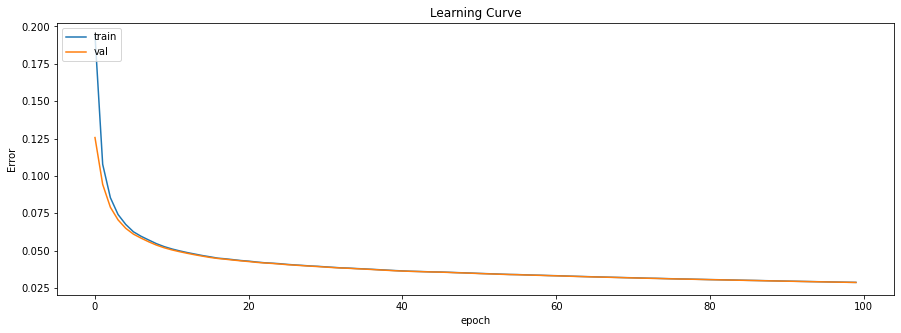

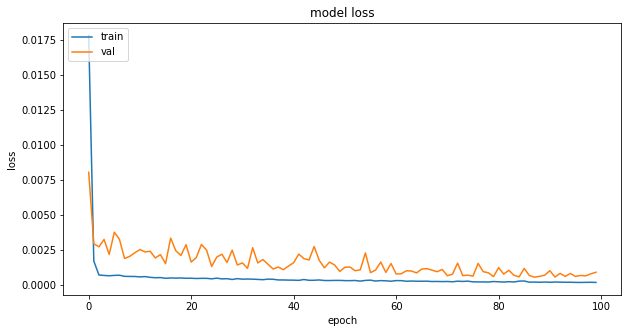

In [41]:
plt.figure(figsize=(15,5))

# summarize history for mae
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Learning Curve')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\mattb\AppData\Local\Temp/ipykernel_10028/2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


C:\Users\mattb\AppData\Local\Temp/ipykernel_10028/2023080546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


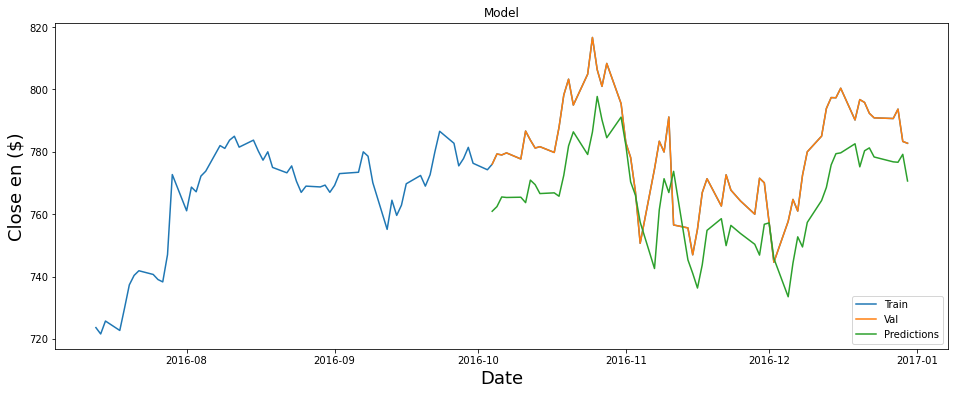

In [22]:
# Plot the data
train = data[-120:]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close en ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Testing new data

In [23]:
df_test = pd.read_csv('Google_Stock_data_test.csv')

In [24]:
df_test["Date"]= pd.to_datetime(df_test["Date"])
df_test.set_index('Date', inplace=True)

In [25]:
dataset_total = pd.concat((df_clean, df_test), axis = 0)

In [26]:
dataset_total

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,7380500.0
2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2012-01-05,329.83,330.75,326.89,657.21,6590300.0
2012-01-06,328.34,328.77,323.68,648.24,5405900.0
2012-01-09,322.04,322.29,309.46,620.76,11688800.0
...,...,...,...,...,...
2017-01-25,829.62,835.77,825.06,835.67,"1,494,500"
2017-01-26,837.81,838.00,827.01,832.15,"2,973,900"
2017-01-27,834.71,841.95,820.44,823.31,"2,965,800"


In [27]:
# Getting the real stock price of 2017

real_stock_price = df_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = dataset_total.filter(['Open'])
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [28]:
# train2 = dataset_total[:len(df_test)]
# valid2 = dataset_total[-len(df_test)+1:]
# valid2['Predictions'] = predicted_stock_price

In [39]:
train2 = dataset_total[-120:]
valid2 = dataset_total.tail(20)
valid2['Predictions'] = predicted_stock_price

C:\Users\mattb\AppData\Local\Temp/ipykernel_10028/3218921091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = predicted_stock_price


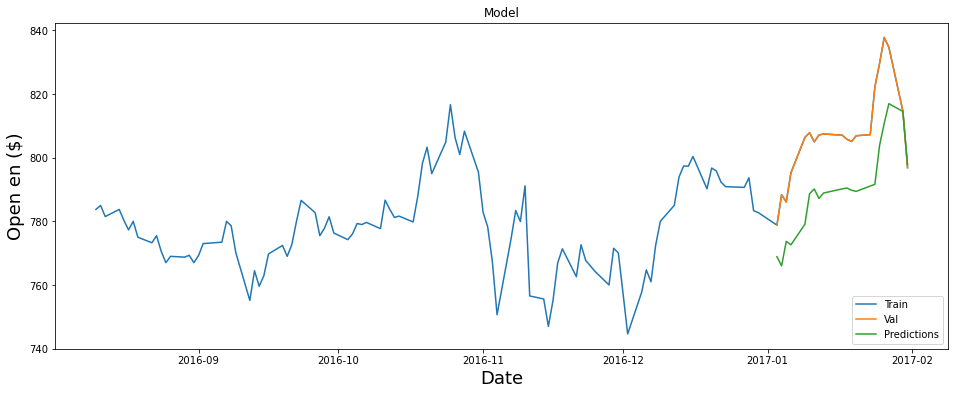

In [40]:

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open en ($)', fontsize=18)
plt.plot(train2['Open'])
plt.plot(valid2['Open'])
plt.plot(valid2[ 'Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

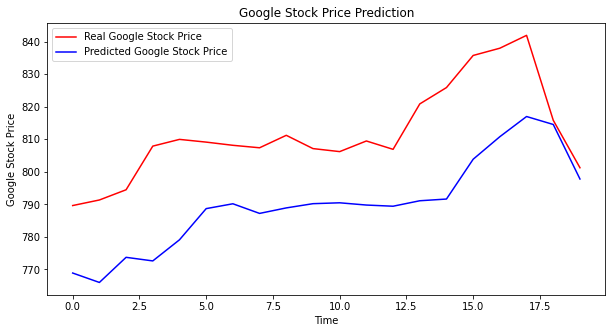

In [31]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Forcasting the first day of february

In [32]:
df_test

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"
2017-01-10,807.86,809.13,803.51,804.79,"1,176,800"
2017-01-11,805.00,808.15,801.37,807.91,"1,065,900"
2017-01-12,807.14,807.39,799.17,806.36,"1,353,100"
2017-01-13,807.48,811.22,806.69,807.88,"1,099,200"


In [33]:
df_feb = pd.read_csv('Google_Stock_data_test.csv')
df_feb.loc[df_feb.shape[0]] = ['2/1/2017',0,0,0,0,'0']
df_feb.set_index('Date', inplace=True)

In [34]:
dataset_total2 = pd.concat((df_clean, df_feb), axis = 0)

In [35]:
# Getting the real stock price of 2017

real_stock_price = df_feb.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total2 = dataset_total2.filter(['Open'])
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_feb = model.predict(X_test)
predicted_stock_price_feb = scaler.inverse_transform(predicted_stock_price_feb)

In [36]:
train2 = dataset_total2[-120:]
valid2 = dataset_total2.tail(20)
valid2['Predictions'] = predicted_stock_price_feb

C:\Users\mattb\AppData\Local\Temp/ipykernel_10028/3356567358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = predicted_stock_price_feb


In [37]:
valid2

,Open,Predictions
Date,,
1/4/2017,788.36,768.884949
1/5/2017,786.08,765.990356
1/6/2017,795.26,773.714478
1/9/2017,806.40,772.608337
1/10/2017,807.86,779.099792
1/11/2017,805.00,788.685547
1/12/2017,807.14,790.175903
1/13/2017,807.48,787.213806
1/17/2017,807.08,788.903870
